In [67]:
%reload_ext autoreload
%autoreload 2

import pyexoplaneteu  # for accesing exoplanet.eu database
import numpy as np
import os
import pandas as pd
import utils as ut
import plot_utils as pu

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'monospace'

Let's first analyze the statistics of the confirmed exoplanet database by looking up how many transists:
- Have host star age determined
- Are transits 
- Both
- How many have erro estimates on the star age

In [68]:
data = pyexoplaneteu.get_data()
df = pd.DataFrame.from_dict(data)

# Count and filter relevant data
total_exos = len(df)
df_t = df[df['detection_type'] == 'Primary Transit']
total_exos_t = len(df_t)
total_exos_age = df['star_age'].count()
total_exos_age_t = df_t['star_age'].count()
total_exos_age_error_t = df_t['star_age_error_min'].count()

# Print statistics
print(f"{total_exos_age} out of {total_exos} ({100 * total_exos_age / total_exos:.2f}%) have host star age determined.")
print(f"{total_exos_t} out of {total_exos} ({100 * total_exos_t / total_exos:.2f}%) are transits.")
print(f"{total_exos_age_t} out of {total_exos_t} ({100 * total_exos_age_t / total_exos_t:.2f}%) transits have host star age.")
print(f"{total_exos_age_error_t} out of {total_exos_t} ({100 * total_exos_age_error_t / total_exos_t:.2f}%) transits have age error estimates.")


2936 out of 5506 (53.32%) have host star age determined.
3809 out of 5506 (69.18%) are transits.
2170 out of 3809 (56.97%) transits have host star age.
2089 out of 3809 (54.84%) transits have age error estimates.


We can now look at the distribution of host star ages for the confirmed transits

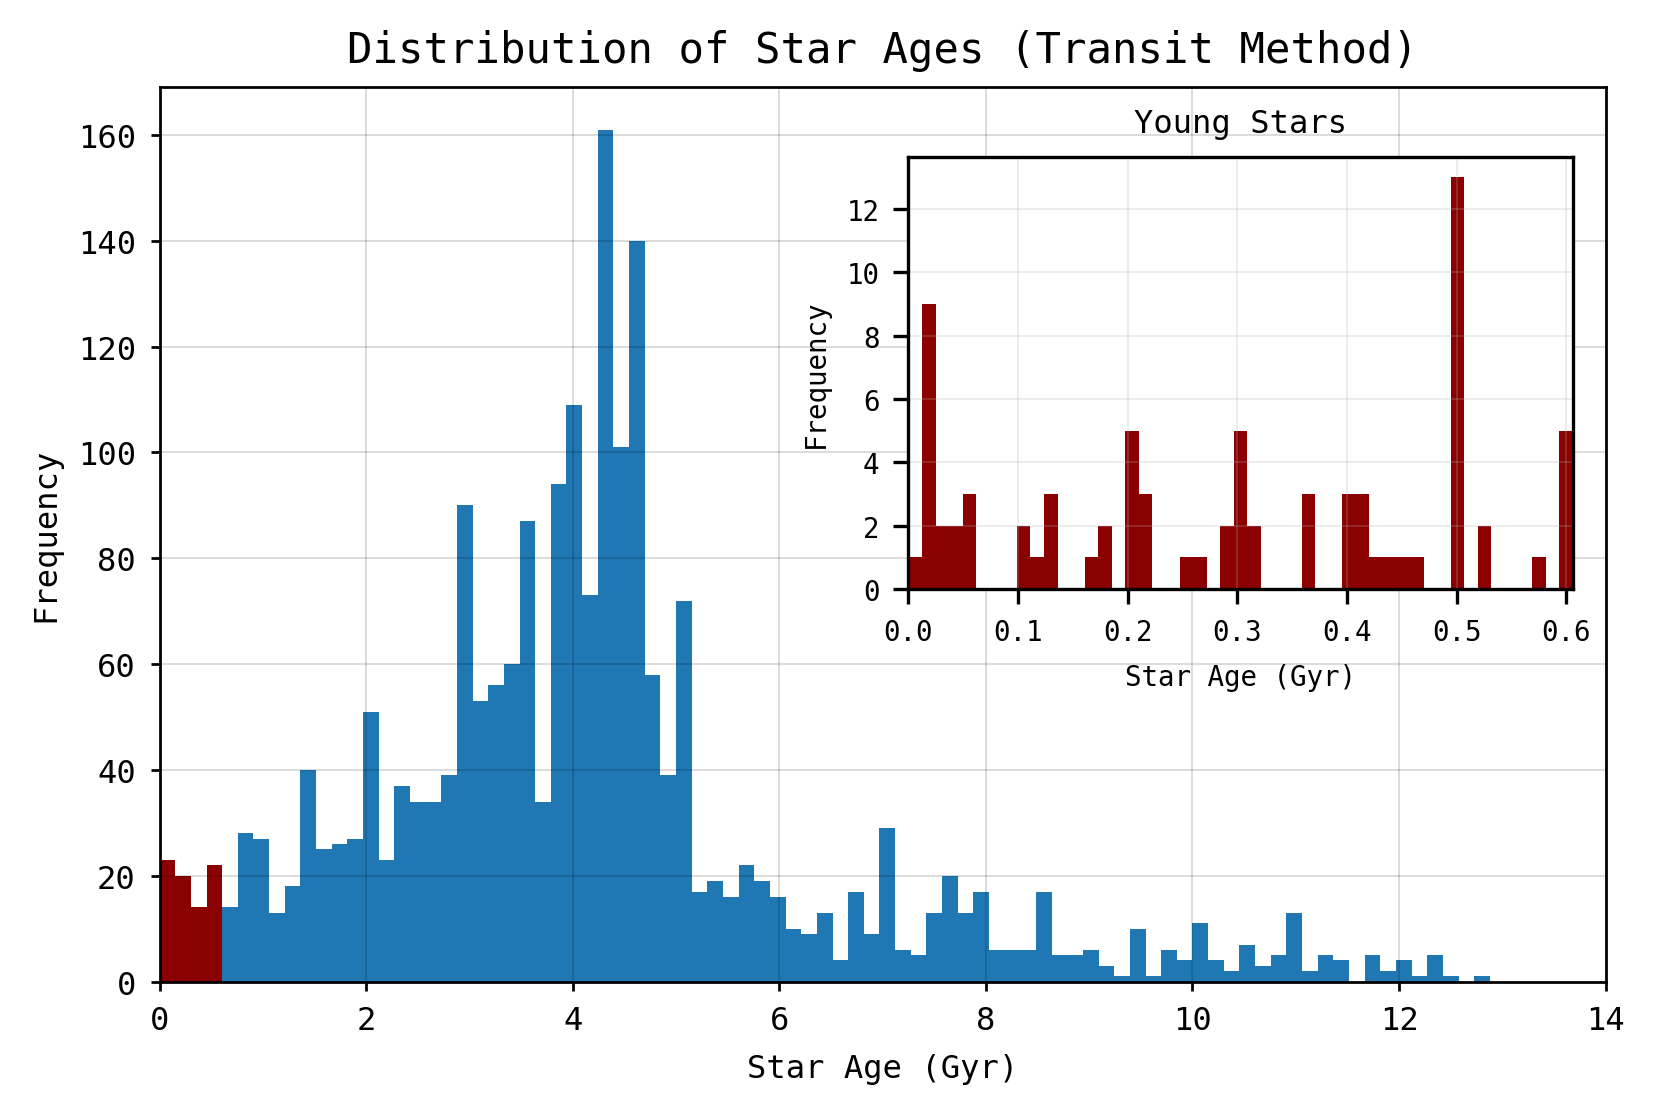

In [69]:
fig, ax, fs = pu.simp_figure(fig_w=1080*3/2, fig_h=1080, 
                             theme=None)

young_lim = 0.606
custom_bins_whole = np.linspace(0, 15, 100)
custom_bins_smol = np.linspace(0, young_lim, 50)

n, bins, patches = ax.hist(df_t['star_age'].dropna(), bins=custom_bins_whole, edgecolor=None, alpha=1)
for i in range(4):
    patches[i].set_facecolor('darkred')

# Set axis labels and title
ax.set_xlabel('Star Age (Gyr)', fontsize=1.75 * fs)
ax.set_ylabel('Frequency', fontsize=1.75 * fs)
ax.tick_params(axis='both', which='major', labelsize=1.75 * fs)


inner_pos=[0.55, 0.47, 0.41, 0.4] 
# Add inner subplot
ax_in = fig.add_axes(inner_pos)
# set tick size and label size of inner subplot

ax_in.tick_params(axis='both', which='major', labelsize=1.5 * fs)
ax_in.set_xlabel('Star Age (Gyr)', fontsize=1.5 * fs)
ax_in.set_ylabel('Frequency', fontsize=1.5 * fs)
ax_in.hist(df_t['star_age'].dropna(), bins=custom_bins_smol, edgecolor=None, alpha=1, color='darkred')
ax_in.set_title('Young Stars', fontsize=1.75 * fs, color='k', zorder=3)
ax_in.grid(which='major', linewidth=fs * 0.025)
ax.set_title('Distribution of Star Ages (Transit Method)', fontsize=2.3 * fs, color='k')

ax.set_xlim([0, 14])
ax_in.set_xlim([0, young_lim])

savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = 'trans_meth_distr_age.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')

plt.show()

Let's now plot the host star ages with their error bars

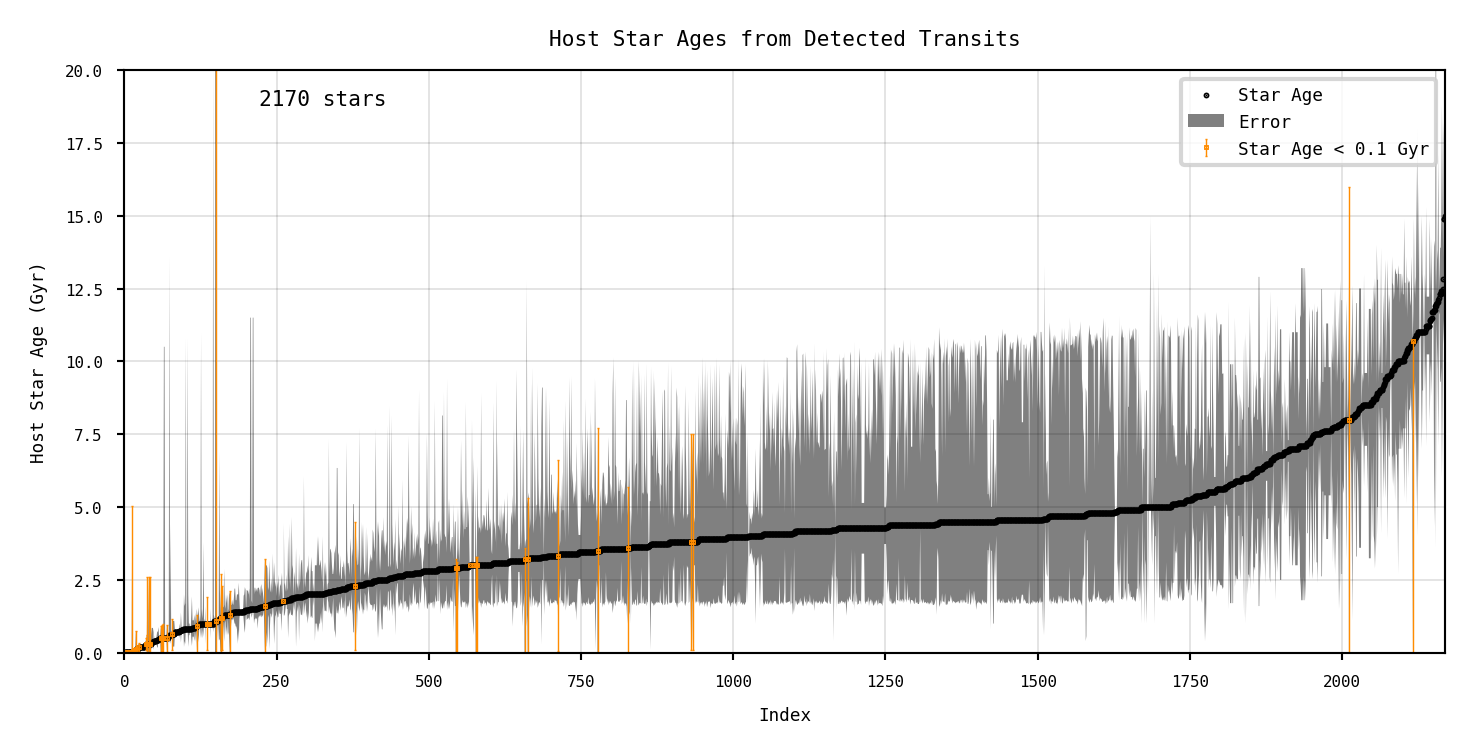

In [70]:
data = pyexoplaneteu.get_data()
df = pd.DataFrame.from_dict(data)

df = df.loc[df.detection_type == 'Primary Transit']  # Filter by exoplanets detected via the transit method
df = df.dropna(subset=['star_age']) # Drop rows with no age information
df = df.sort_values(by='star_age').reset_index(drop=True)  # Sort by host star age
df['star_age_error_min'].fillna(0, inplace=True)


age_lim = 0.1  # This is the age limit in Gyr for considering a star young
df_filt = df.loc[df['star_age'] - np.abs(df['star_age_error_min']) < age_lim]

# Initialize plot using function defined in the plot_utils.py file
rat = 2
size = 720
fig_w, fig_h = size*rat, size
subplots = (1, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, ratio=None, theme=None, subplots=subplots, text_size=0.75)
ax = axs[0][0]
ms, capsize, ew = 0.05, 0.1, 0.1

x, y, yerr = ut.get_params(df)
yerr_lower, yerr_upper = yerr

y2, yerr_lower2, yerr_upper2 = [], [], []
for i, val in enumerate(y):
    if val - yerr[0][i] < age_lim:
        y2.append(val)
        yerr_lower2.append(yerr[0][i])
        yerr_upper2.append(yerr[1][i])
    else:
        y2.append(np.nan)
        yerr_lower2.append(np.nan)
        yerr_upper2.append(np.nan)
yerr2 = [yerr_lower2, yerr_upper2]

# Plot the data points
ax.scatter(x, y, color='black', label='Star Age', s=ms*fs, zorder=2)

# Plot the error as filled region
ax.fill_between(x, y - yerr_lower, y + yerr_upper, color='grey', alpha=1, lw=0, zorder=1, label='Error')
ax.errorbar(x, y2, yerr2, fmt='s', color='darkorange', ecolor='darkorange', 
            capsize=capsize*fs, markersize=ms*fs, elinewidth=ew*fs, capthick=ew*fs, 
            label=f'Star Age < {age_lim} Gyr')

ax.set_title('Host Star Ages from Detected Transits', fontsize=fs*1.5)
ax.set_xlabel('Index', fontsize=fs*1.25)
ax.set_ylabel('Host Star Age (Gyr)', fontsize=fs*1.25)
ax.legend(loc='upper right', fontsize=fs*1.25)

ax.set_ylim(0, 20)
ax.set_xlim(0, x[-1])

#text in the middle with the number of stars
ax.text(0.15, 0.95, f'{len(y2)} stars', fontsize=fs*1.5, transform=ax.transAxes, ha='center', va='center')

savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = 'sorted_host_star_ages.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')

plt.show()


Comments about figure above:
 - Some top error bars are gigantic (we take those as they are)
 - Some bottom error bars are also very big, which does not make sense as it would mean negative values for the star age.
 - Some host stars may be duplicated! This is because several different planets may have been detected via transit method around the same host star. 

### Cumulative Distribution of Stars by Age: Considering Error Bars

The following cell generates a bar plot that visualizes the cumulative distribution of transits whose host star age lays under a certain age limit. The graph has two sets of bars:

1. **Considering low error bound**: This set represents the number of stars that fall below each age threshold when taking into account the lower error bound.
2. **No error considered**: This set represents the raw count of stars that fall below each age threshold, without considering any error bars.

The x-axis indicates the age thresholds (in Gyr), and the y-axis shows the number of confirmed transits whose host star falls below each age threshold.

By analyzing this distribution, we aim to understand how accounting for error in the age measurements affects our perspective on the population of host stars.


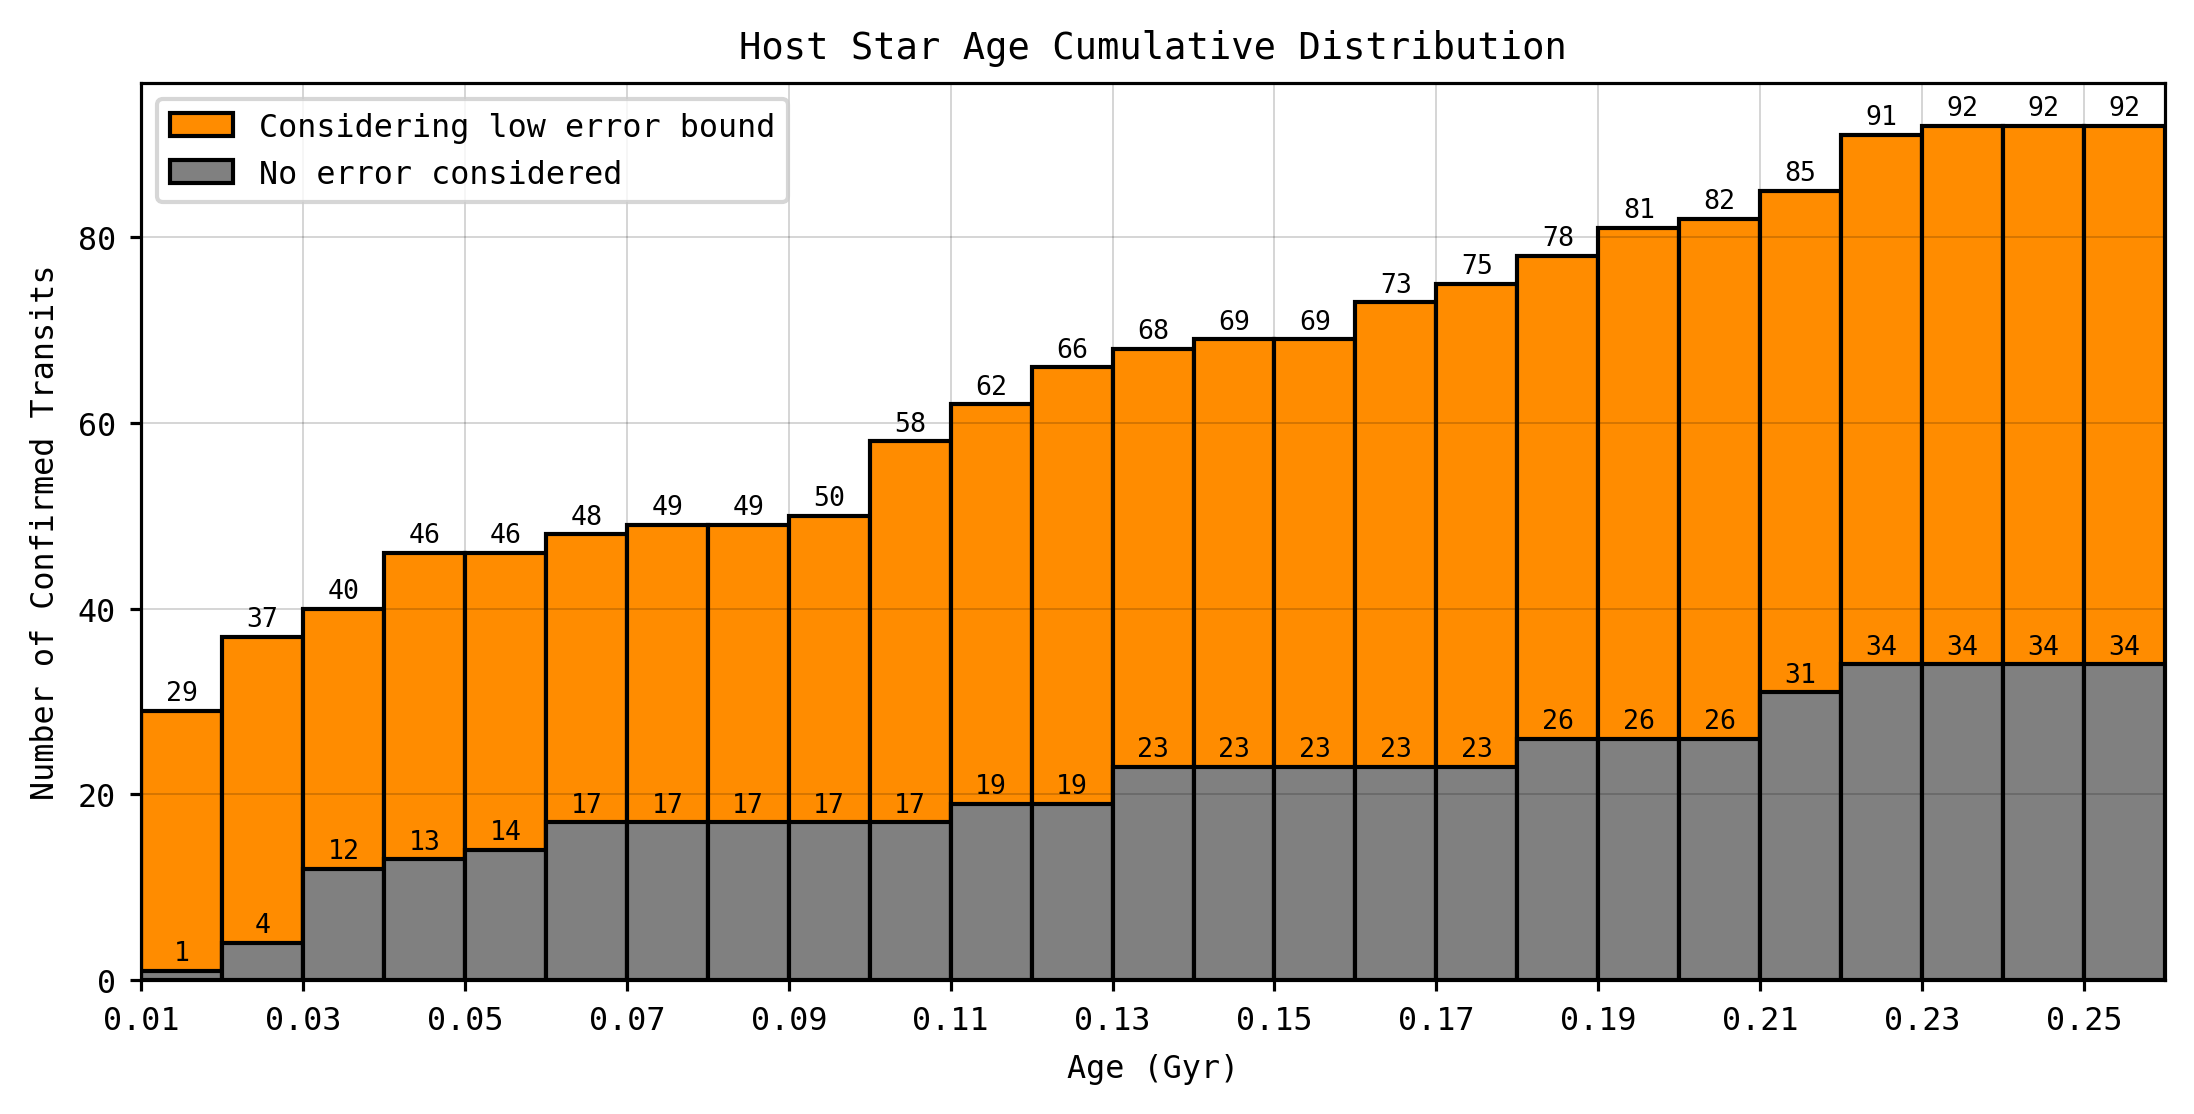

In [71]:
vals = np.linspace(0.01, 0.25, 25)

nums = []
nums_lowerr = []
for val in vals:
    # Indices where y < 0.2
    indices_y = np.where(y < val)[0]
    indices_y2 = np.where(y - yerr_lower < val)[0]
    nums.append(len(indices_y))
    nums_lowerr.append(len(indices_y2))

fig, ax, fs = pu.simp_figure(fig_w=1080*4/2, fig_h=1080, 
                             theme=None)


bar_width = vals[1] - vals[0]  # or any other appropriate value for your data

ax.bar(vals, nums_lowerr, width=bar_width, 
       color='darkorange',
       edgecolor='k', align='edge', label='Considering low error bound')
ax.bar(vals, nums, width=bar_width, 
       color='gray',
       edgecolor='k', align='edge', label='No error considered')

# add the value on top of bars
for i, val in enumerate(vals):
    ax.text(val+bar_width/2, nums[i]+0.5, nums[i], ha='center', va='bottom', fontsize=fs*1.25)
    ax.text(val+bar_width/2, nums_lowerr[i]+0.5, nums_lowerr[i], ha='center', va='bottom', fontsize=fs*1.25)


# Customization like title, labels, legend
ax.set_title('Host Star Age Cumulative Distribution', fontsize=fs*1.75)
ax.set_ylabel('Number of Confirmed Transits', fontsize=fs*1.5)
ax.set_xlabel('Age (Gyr)', fontsize=fs*1.5)
ax.legend(loc='upper left', fontsize=fs*1.5)



ax.set_xticks(vals[::2])
ax.set_xlim(0.01, 0.26) 

savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = 'cum_age_error_plot.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')

plt.show()


In [72]:
text = f'From the {len(df)} stars with confirmed transits whose host star age is determined, {len(df_filt)} are younger than {age_lim} Gy considering error bars.'
print(text)

From the 2170 stars with confirmed transits whose host star age is determined, 59 are younger than 0.1 Gy considering error bars.


Again, this is the number of transists. If we want to get the actual number of different host stars we should do some filtering. Done below.

We make a dictionary where star is the key and planets are the values

In [100]:
df_filt = df.loc[df['star_age'] - np.abs(df['star_age_error_min']) < age_lim]
df_filt = df_filt.sort_values(by='star_age').reset_index(drop=True)  # Sort by host star age
planet_list = df_filt['name']
# Initialize an empty dictionary to store the stars and their planets
star_planet_dict = {}
# Iterate through the list of planets
for entry in planet_list:
    # Split the entry into star and planet
    star, planet = entry.rsplit(' ', 1)
    
    # If the star is already in the dictionary, append the new planet
    if star in star_planet_dict:
        star_planet_dict[star].append(planet)
    else:
        # If the star is not in the dictionary, add it with the planet as the first entry in the list
        star_planet_dict[star] = [planet]

print(f'The final list has {len(star_planet_dict)} host stars and is \n')
# The final list of stars are
star_list = list(star_planet_dict.keys())
for star in star_list:
    print(f'{star} ({len(star_planet_dict[star])} planets)')

The final list has 46 host stars and is 

K2-33 (1 planets)
HD 114082 (1 planets)
1SWASP J1407 (1 planets)
HIP 67522 (1 planets)
AU Mic (2 planets)
V1298 Tau (4 planets)
TOI-1097 (2 planets)
Kepler-1627 (1 planets)
DS Tuc A (1 planets)
TOI-942 (2 planets)
NGTS-7A (1 planets)
CoRoT-20 (1 planets)
HIP 94235 (1 planets)
K2-284 (1 planets)
TOI-251 (1 planets)
TOI-1268 (1 planets)
TOI-1431 (1 planets)
Kepler-51 (3 planets)
TOI-540 (1 planets)
Kepler-462 (2 planets)
WASP-59 (1 planets)
WASP-18 (1 planets)
WASP-101 (1 planets)
K2-3 (3 planets)
WASP-129 (1 planets)
OGLE-TR-10 (1 planets)
WASP-172 (1 planets)
HATS-52 (1 planets)
HATS-50 (1 planets)
WASP-89 (1 planets)
WASP-24 (1 planets)
Kepler-17 (1 planets)
WASP-16 (1 planets)
Kepler-437 (1 planets)
Kepler-442 (1 planets)
CoRoT-10 (1 planets)
CoRoT-8 (1 planets)
Kepler-436 (2 planets)
Kepler-443 (1 planets)
WASP-58 (1 planets)
HIP 97166 (1 planets)
TOI-2364 (1 planets)
WASP-60 (1 planets)
GJ 143 (2 planets)
WASP-96 (1 planets)
TOI-1420 (1 pla

Let's see the distribution of stars with the number of orbiting planets (detected by transit method)

In [101]:
planet_count_frequency = {}

# Count the number of planets for each star
for star, planets in star_planet_dict.items():
    num_planets = len(planets)
    if num_planets in planet_count_frequency:
        planet_count_frequency[num_planets] += 1
    else:
        planet_count_frequency[num_planets] = 1

# sort dic by value
planet_count_frequency = dict(sorted(planet_count_frequency.items(), key=lambda item: item[1], reverse=True))

# make a rint out of results above
print('The number of planets per star are \n')
for num_planets, frequency in planet_count_frequency.items():
    print(f'{num_planets} planets: {frequency} stars')

The number of planets per star are 

1 planets: 37 stars
2 planets: 6 stars
3 planets: 2 stars
4 planets: 1 stars


Let's go a step further and get the name of the mission these planets were detected from. For that we need the NASA database that we previously have downloaded. Finally we save the results into a .txt

In [103]:
from astropy.io import votable

# Load the data (takes around 15s)
data_NASA = votable.parse_single_table('../data/database_NASA.votable')
data_NASA = data_NASA.to_table().to_pandas()

In [105]:
# Get the final list of star names, with number of orbiting planets and mission
# save it as .txt file

star_names = list(star_planet_dict.keys())
star_numbers = [len(star_planet_dict[star]) for star in star_names]

star_mission_dict = {}
star_mission_exo = [None]*len(star_names)
for index, name in enumerate(star_names):
    filtered_data = data_NASA['disc_facility'].loc[data_NASA['hostname'] == name]
    if not filtered_data.empty:
        star_mission_dict[name] = filtered_data.iloc[0]
    else:
        star_mission_dict[name] = None

savefold = '../results/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'young_stars_below_{age_lim*1e3:0.0f}Myr.txt'
savepath = savefold + figname

headers = ['Host star name', '# transit planets', 'Mission']

with open(savepath, 'w') as f:
    # Write the header first
    f.write(f"{headers[0]:<25}  {headers[1]:<25}  {headers[2]:<25}\n")
    f.write("="*100 + "\n")  # Optional: to separate the header and the data with a line
    
    # Now write the data
    for star in star_list:
        f.write(f"{star:<25}  {len(star_planet_dict[star]):<25}  {star_mission_dict[star]}\n")